In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

In [3]:
# pluto = gpd.read_file("C:\Users\daiyu\Documents\GitHub\cdp-mapping-systems\Data\nyc_mappluto_24v1_1_shp\MapPLUTO.shp.xml")

In [4]:
pluto_ogrio = ogr.read_dataframe(r"C:\Users\daiyu\Documents\GitHub\cdp-mapping-systems\Data\nyc_mappluto_24v1_1_shp\MapPLUTO.shp")

In [5]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [6]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

In [7]:
pluto_ogrio.LandUse.value_counts()

LandUse
01    565933
02    131623
04     55966
11     24904
05     21260
03     12916
08     12052
06      9431
10      9344
07      6033
09      4708
Name: count, dtype: int64

In [10]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [11]:
pluto_ogrio["LandUse"] = pluto_ogrio.LandUse.map(land_use_codes)

In [12]:
pluto_ogrio.groupby(["LandUse","Lot"])

Text(0.5, 1.0, 'Total lot area by land use type')

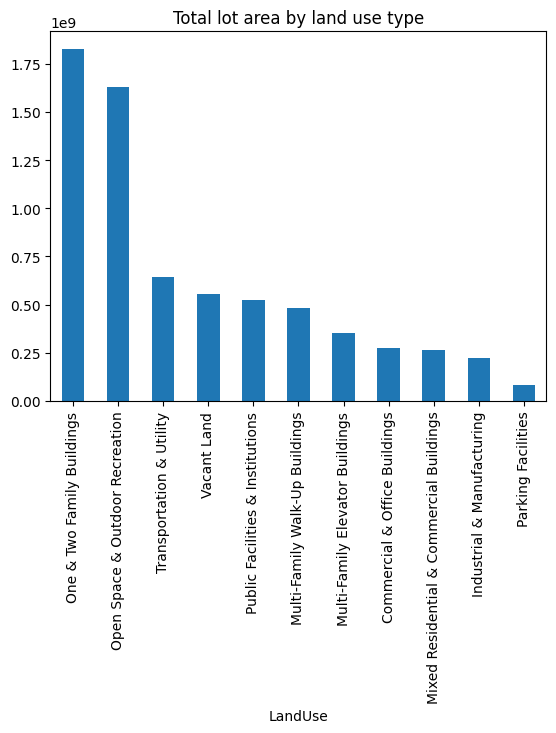

In [13]:
pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")